# Duration and Traction in Starting a Podcast

## 15 October, 2023

## Joseph Rush

### Hypothesis
When starting a new podcast, listeners will be less willing to start with long episodes. So, when a podcast is first starting out, it will tend to have shorter, more contained episodes, probably less than an hour, and if they move into a longer length it will be a steady lengthening over time as they gain audience and traction.

I am testing this hypothesis with episode data from the most popular podcast on Spotify on 10/2/23, "New Heights with Jason and Travis Kelce." As a podcast with a large listener base, it is a good test case for what best practices are to grow an audience.

### Methodology

To test this hypothesis, I will be using the Get Show Episodes endpoint. This will pull episodes of a single podcast with title, date, and length information, which will allow me to conduct my time-based analysis of length.

The main limitation to this approach is that one podcast is not an ideal representation of a market segment. A more broad and inclusive study would include information from many podcasts, with multiple additional layers of analysis for context, role in an existing property, brand, or ecosystem, podcast genre, and a multitude of other factors. Creative endeavors are complicated, and quantifying them is even moreso.

This data also only includes Spotify and is not a cohesive picture across listening platforms. Apple, Spotify, IHeartRadio, and many other services host podcasts. To get a cohesive idea of a podcast's traction and growth, one would have to scrape a multitude of platforms.

First, getting my ducks in a row with Spotify API credentials

In [43]:
# Setup
import requests as rq
import pandas as pd
import base64 # Remove in final
import json
import urllib # Remove in final
import matplotlib.pyplot as plt 
import numpy as np 

# Spotify credential retrieval from local storage

client_id = pd.read_csv('230919-SpotifyCredentials.txt')['Client_ID'].iloc[0]
client_secret = pd.read_csv('230919-SpotifyCredentials.txt')['Client_Secret'].iloc[0]

# Encode Spotify client credentials into ascii for use in requests
client_cred = base64.b64encode(str(client_id + ":" + client_secret).encode("ascii"))

# Turn client_cred into acceptable header
headers = {"Authorization": "Basic {}".format(client_cred.decode("ascii"))}

# Define more arguments to authorize access
payload = {'grant_type' : 'client_credentials'}
url = 'https://accounts.spotify.com/api/token'

# Check if Spotify likes my credentials. 200 is success
session_key_response = rq.post(url = url, data = payload, headers = headers)
session_key_response.status_code

200

In [44]:
# Grab & store necessary access information
session_header_key = session_key_response.json()['access_token']

# Pass provided access_token key into headers of my actual request
session_headers ={"Authorization": "Bearer {}".format(session_header_key)}

Next, I pull in the Spotify podcast IDs I gathered in a csv

In [45]:
# method to import .csv with all the Spotify API links
pod_list_df = pd.read_csv('SpotifyTop50Podcasts_231002.csv')

## The Podcast

The most popular podcast on 10/2/23 was "New Heights with Jason and Travis Kelce." It is the first item in my csv of the top 48 most popular podcasts that I gathered on the same day. I will be gathering the maximum number of episodes allowed in a single call, 50, and using an offset of 10 so that I can pull episodes 1-50.

In [46]:
# Define search URL
show_episodes_url = 'https://api.spotify.com/v1/shows/{}/episodes?market=US&limit=50&offset=10'.format(pod_list_df['Spotify ID'][0])

In [47]:
# Create search URL
showEpisodes = rq.get(url = show_episodes_url, headers = session_headers)
showEpisodes.status_code

200

In [48]:
# Load in the resulting data as a json
showEpisodes_json = json.loads(showEpisodes.text)

In [49]:
showEpisodes_json.keys()

dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

Now, I find myself confronted with the fact that all the information I want (name, release_date, duration_ms) are within the "items" key in the response, so I have to go in and pull the information I need.

#### Episode Names

In [50]:
# Define a method to pull the Name values from the Items key

def find_values_by_key(showEpisodes_json, key_to_find):
    names = []

    # Check if the current data is a dictionary
    if isinstance(showEpisodes_json, dict):
        for key, value in showEpisodes_json.items():
            if key == key_to_find:
                names.append(value)
            else:
                names.extend(find_values_by_key(value, key_to_find))

    # Check if the current data is a list (array)
    elif isinstance(showEpisodes_json, list):
        for item in showEpisodes_json:
            names.extend(find_values_by_key(item, key_to_find))

    return names

# Which key do I want?
key_to_find = 'name'

# Run the method
names = find_values_by_key(showEpisodes_json, key_to_find)

# print(names)

Now, I can make a DataFrame with all of the episode names and start adding my dates and durations as additional columns

In [51]:
new_df = pd.DataFrame(names)
new_df.head()

,0
0,"Julian Edelman on His Brady Relationship, Bein..."
1,"Travis Dominates The Match, Jason Goes Full Co..."
2,"The Beer Bowl with Landon Dickerson, Jeff Stou..."
3,"Alejandro Villanueva on his NFL Career, Servin..."
4,"Mahomes Who, Best Throwbacks, and Whale Wars |..."


#### Release Dates

In [52]:
# Define a method to pull the Release Date values from the Items key

def find_values_by_key(showEpisodes_json, key_to_find):
    dates = []

    # Check if the current data is a dictionary
    if isinstance(showEpisodes_json, dict):
        for key, value in showEpisodes_json.items():
            if key == key_to_find:
                dates.append(value)
            else:
                dates.extend(find_values_by_key(value, key_to_find))

    # Check if the current data is a list (array)
    elif isinstance(showEpisodes_json, list):
        for item in showEpisodes_json:
            dates.extend(find_values_by_key(item, key_to_find))

    return dates

# Which key do I want?
key_to_find = 'release_date'

# Find my values
dates = find_values_by_key(showEpisodes_json, key_to_find)

# print(dates)

#### Milliseconds

In [54]:
# Define a method to pull the Millisecond values from the Items key

def find_values_by_key(showEpisodes_json, key_to_find):
    length = []

    # Check if the current data is a dictionary
    if isinstance(showEpisodes_json, dict):
        for key, value in showEpisodes_json.items():
            if key == key_to_find:
                length.append(int(value))
            else:
                length.extend(find_values_by_key(value, key_to_find))

    # Check if the current data is a list (array)
    elif isinstance(showEpisodes_json, list):
        for item in showEpisodes_json:
            length.extend(find_values_by_key(item, key_to_find))

    return length

# Which key do I want?
key_to_find = 'duration_ms'

# Find my values
length = find_values_by_key(showEpisodes_json, key_to_find)

# print(length)

In [55]:
new_df['Milliseconds'] = length
new_df.head()

,0,Release Date,Milliseconds
0,"Julian Edelman on His Brady Relationship, Bein...",2023-07-19,5624084
1,"Travis Dominates The Match, Jason Goes Full Co...",2023-07-12,2759706
2,"The Beer Bowl with Landon Dickerson, Jeff Stou...",2023-07-06,4754677
3,"Alejandro Villanueva on his NFL Career, Servin...",2023-06-30,5596133
4,"Mahomes Who, Best Throwbacks, and Whale Wars |...",2023-06-21,3798125


Now, I just need to quickly deal with the fact that my episodes are arranged newest to oldest, instead of oldest to newest.

In [65]:
final_df = new_df.loc[::-1].reset_index(drop=True)
final_df.head()

,0,Release Date,Milliseconds
0,"New Offenses, Last Dances and Epic Super Bowl ...",2022-09-08,3614380
1,"Chiefs Offense, Eagles Playmakers and TNF Game...",2022-09-14,3054915
2,"Body Slams, Blown Leads and Days Off | New Hei...",2022-09-21,4877557
3,"Big Plays, Butt Punts and Brady Stories | New ...",2022-09-28,4741250
4,"Best Tight Ends, Bad Media and Birthdays with ...",2022-10-05,5323415


Now, the episodes are arranged in chronological order. 
On to making a graph!

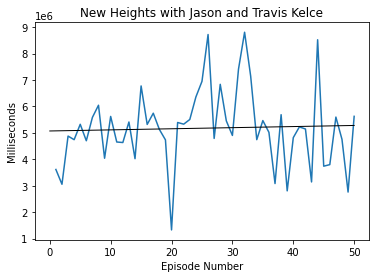

In [59]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
y = final_df['Milliseconds']

fig1, ax1 = plt.subplots()

plt.plot(x,y)
plt.xlabel("Episode Number") 
plt.ylabel("Milliseconds")
plt.title("New Heights with Jason and Travis Kelce")

b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(0, 50, num=50)
ax1.plot(xseq, a + b * xseq, color="k", lw=1)

plt.show()

Doing some quick conversions from milliseconds to hours, minutes, and seconds, we find the following four episodes defining the extremes of the values

The first episode was "New Offenses, Last Dances and Epic Super Bowl Rings" at __1 hour, 0 minutes, and 14 seconds__.

The longest episode was Episode 31, "Jason’s Coming Back, Rodgers Decision & Nick Sirianni," at __2 Hours, 26 Minutes 45 Seconds__.

The shortest episode was Episode 19, "Playoff Football, Pro Bowl Memories & JJ Watt Retires" at __22 Minutes, 8 Seconds__.

The most recent episode was Episode 49, "Julian Edelman on His Brady Relationship, Being Scared of Belichick and Randy Moss' Hot Tub," at __1 Hour, 33 Minutes, 44 Seconds__. (Somewhere within the episodes seems to have been some kind of special episode that did not receive a full episode number).

## Conclusion

My hypothesis was not supported by the data. The length trend, as shown by the black line of best fit on the graph, has undergone almost no change. The episode lengths, based on the dates and titles, seem to vary seasonally or by subject, rather than following any general trend. This seems to represent a case study in fitting length to content, rather than approaching content with a length in mind.

The logical and effective expansion of this analysis would be to grab data from many podcasts, dozens or even hundreds, that have performed well. These podcasts would need to be analyzed for genre, creator, date, platform, and more to provide a more cohesive picture of launching a show and gaining audience traction. This expanded data should also be gathered on a variety of platforms, since podcasts can gain more or less traction on one platform or another based on user preferences and algorithmic biases.